In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from data_handler import DataHandler
from modelling.fit_image import load_model
from pytorch3d.ops import interpolate_face_attributes
from pytorch3d.renderer.mesh.shading import _apply_lighting
from pytorch3d.renderer import Materials

%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dh = DataHandler('people/CFD/LF-249/', device)
#dh = DataHandler('people/CFD/WM-256/', device)
model, optimizer = load_model(dh.quarter_individual, dh.folder, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


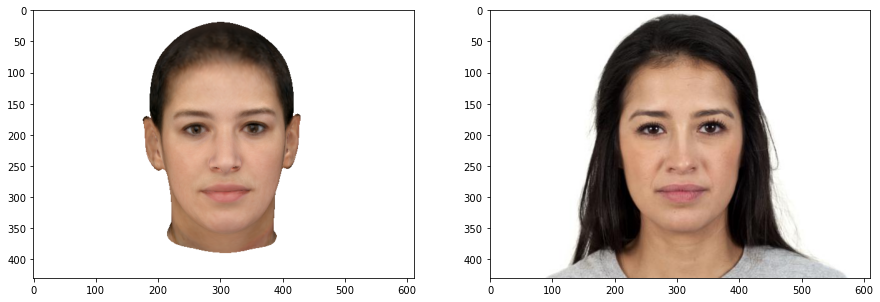

In [4]:
_, image_init = model()
_, axs = plt.subplots(1, 2, figsize=(15, 15))
axs = axs.flatten()
axs[0].imshow(image_init[0, ..., :3].detach().cpu().numpy())
axs[1].imshow(model.individual.source_image.detach().cpu())
plt.show()

In [6]:
mesh = model.face_model.compute_face()
fragments = model.render_model.renderer.rasterizer(mesh)

In [34]:
camera = model.render_model.camera
texels = mesh.sample_textures(fragments)
lights = model.render_model.light
materials = Materials(ambient_color = torch.zeros((1, 3)),
                                  diffuse_color = torch.ones((1, 3)),
                                  specular_color = torch.zeros((1, 3)),
                                  shininess = torch.tensor([64.0]).to(device),
                                  device = device)

In [35]:
verts = mesh.verts_packed()  # (V, 3)
faces = mesh.faces_packed()  # (F, 3)
vertex_normals = mesh.verts_normals_packed()  # (V, 3)
faces_verts = verts[faces]
faces_normals = vertex_normals[faces]
pixel_coords = interpolate_face_attributes(
        fragments.pix_to_face, fragments.bary_coords, faces_verts
    )
pixel_normals = interpolate_face_attributes(
        fragments.pix_to_face, fragments.bary_coords, faces_normals
    )
ambient, diffuse, specular = _apply_lighting(
        pixel_coords, pixel_normals, lights, camera, materials
    )

In [36]:
diffuse.squeeze().shape

torch.Size([430, 611, 3])

In [37]:
model.individual.source_image.detach().cpu().shape

torch.Size([430, 611, 3])

In [38]:
new_image = model.individual.source_image / diffuse.squeeze()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


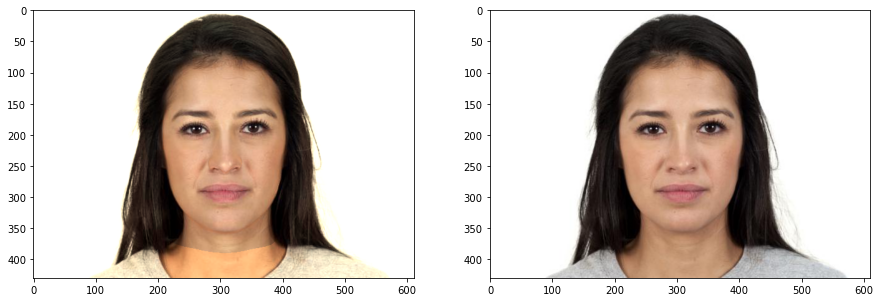

In [39]:
_, axs = plt.subplots(1, 2, figsize=(15, 15))
axs = axs.flatten()
axs[0].imshow(new_image.detach().cpu().numpy())
axs[1].imshow(model.individual.source_image.detach().cpu())
plt.show()